In [1]:
# IMPORT PACKAGES
from sklearn.neighbors import KDTree
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time

np.random.seed(0)

In [40]:
# QUESTION 1: Functions

# Cross validation function
# INPUT: All datasets (NxD np.arrays (X), Nx1 np.arrays (Y)), k (int), # partitions (int), whether to plot prediction curves (bool)
# OUTPUT: Loss for L1, L2 (floats)
def cross_validation_k(x_train, y_train, x_valid, y_valid, k, partitions=5, plot=False):
    start = time.time()
    
    # Combine train and validation sets
    x_cross = np.vstack([x_valid,x_train])
    y_cross = np.vstack([y_valid,y_train])
    
    # Create partitions of indices
    indices = np.arange((x_cross.shape[0]))
    np.random.shuffle(indices)
    part = np.array_split(indices, partitions)
    
    avg_predictions_l1 = np.zeros((x_cross.shape[0],1))
    avg_predictions_l2 = np.zeros((x_cross.shape[0],1))
    
    for i in range(len(part)):
        # Find indices for holdout, training
        holdout = part[i]
        train = np.array([])
        
        for j in range(len(part)):
            if j==i:
                continue
            else:
                train = np.append(train,np.array(part[j]))
        train = train.astype(int)
        
        x_nhold = x_cross[train] # Neighbours: X-values with known Y
        y_nhold = y_cross[train] # Neighbours: Known Y
        x_hold = x_cross[holdout] # Test points: "Unknown" Y
        y_hold = y_cross[holdout] # Test points: Y for testing
            
        # Find k-NN generated values for all x_cross in holdout
        y_knn_l1 = np.array([[]])
        y_knn_l2 = np.array([[]])
        
        for x_val in x_hold:
            y_knn_l1 = np.append(y_knn_l1, knn_regression_l1(x_nhold, y_nhold, x_val, k))
            y_knn_l2 = np.append(y_knn_l2, knn_regression_l2(x_nhold, y_nhold, x_val, k))
        
        y_knn_l1 = np.c_[y_knn_l1]
        y_knn_l2 = np.c_[y_knn_l2]
        
        for val in range(y_knn_l1.shape[0]):
            avg_predictions_l1[holdout[val],0] = y_knn_l1[val]
            avg_predictions_l2[holdout[val],0] = y_knn_l2[val]
        
    # After running through the whole fold, find the average losses:
    avgloss_l1 = RMSEloss(y_cross,avg_predictions_l1)
    avgloss_l2 = RMSEloss(y_cross,avg_predictions_l2)

    if plot==True:
        fig, ax = plt.subplots(1)
        ax.plot(x_cross,y_cross)
        ax.set_title('Actual Cross-Validation Curve'.format(k))
        ax.set_xlabel('Time')
        ax.set_ylabel('CO2 Levels')
        plt.show()        
        
        fig, ax = plt.subplots(1)
        ax.plot(x_cross,avg_predictions_l2)
        ax.set_title('Cross-Validation Prediction Curve for L2, K = {}'.format(k))
        ax.set_xlabel('Time')
        ax.set_ylabel('CO2 Levels')
        plt.show()
        
    print("CV | K-Value: {} | Average loss for L1: {} | Average loss for L2: {} | Time = {}s".format(k,avgloss_l1,avgloss_l2,(time.time()-start)))
    return avgloss_l1, avgloss_l2
      
# Test function
# INPUT: All datasets (NxD np.arrays (X), Nx1 np.arrays (Y)), k (int), whether to plot prediction curves (bool)
# OUTPUT: Loss for L1, L2 (floats)
def test_k(x_train, y_train, x_valid, y_valid, x_test, y_test, k, plot=False):
    start = time.time()
    
    x_nns = np.vstack([x_valid,x_train])
    y_nns = np.vstack([y_valid,y_train])
    
    y_knn_l1_test = np.array([[]])
    y_knn_l2_test = np.array([[]])
    
    for ind in x_test:       
        y_knn_l1_test = np.append(y_knn_l1_test, knn_regression_l1(x_nns, y_nns, ind, k))
        y_knn_l2_test = np.append(y_knn_l2_test, knn_regression_l2(x_nns, y_nns, ind, k))
    
    y_knn_l1_test = np.c_[y_knn_l1_test]
    y_knn_l2_test = np.c_[y_knn_l2_test]
    
    if plot==True:
        fig, ax = plt.subplots(1)
        ax.plot(x_test,y_test)
        ax.set_title('Actual Test Curve'.format(k))
        ax.set_xlabel('Time')
        ax.set_ylabel('CO2 Levels')
        plt.show() 
        
        fig, ax = plt.subplots(1)
        ax.plot(x_test,y_knn_l2_test)
        ax.set_title('Test Prediction Curve for L2, K = {}'.format(k))
        ax.set_xlabel('Time')
        ax.set_ylabel('CO2 Levels')
        plt.show()
    
    testloss_l1 = RMSEloss(y_test,y_knn_l1_test)
    testloss_l2 = RMSEloss(y_test,y_knn_l2_test)
    
    print("Test | K-Value: {} | Average loss for L1: {} | Average loss for L2: {} | Time = {}s".format(k,testloss_l1,testloss_l2,(time.time()-start)))
    return testloss_l1, testloss_l2

# Euclidean (2-norm) regression
# INPUT: X and Y training datasets (NxD np.array (X), Nx1 np.array (Y)), test point x_test[i] (1xD np.array), k (int)
# OUTPUT: Prediction for y_test[i] (1x1 np.array)
def knn_regression_l1(x_train, y_train, x_test, k):
    # 2-NORM: Euclidean Distance
    # Get indices of k nearest neighbors
    dist = np.sqrt(np.sum(np.square(x_train-x_test), axis=1))
    i_nn = np.argpartition(dist, kth=k)[:k]
    
    # Take the average of points in the partition
    test_val = np.average(y_train[i_nn])
    
    return test_val

# Manhattan (1-norm) regression
# INPUT: X and Y training datasets (NxD np.array (X), Nx1 np.array (Y)), test point x_test[i] (1xD np.array), k (int)
# OUTPUT: Prediction for y_test[i] (1x1 np.array)
def knn_regression_l2(x_train, y_train, x_test, k): 
    # 1-NORM: Manhattan Distance
    # Get indices of k nearest neighbors
    dist = (np.sum(abs(x_train-x_test), axis=1))
    i_nn = np.argpartition(dist, kth=k)[:k]
    
    # Take the average of points in the partition
    test_val = np.average(y_train[i_nn])
    return test_val

# RMSE Loss Function
# INPUT: Predicted Y array, actual Y array (Nx1 np.arrays)
# OUTPUT: Loss (float)
def RMSEloss(y_real,y_pred):
    return np.sqrt(np.mean((y_pred-y_real)**2))


# Plot Loss Curve
# INPUT: All datasets (NxD np.arrays (X), Nx1 np.arrays (Y)), whether to plot cross validation (True) or test curve (bool)
# OUTPUT: None (plots are printed)
def plot_loss(x_train, y_train, x_valid, y_valid, x_test, y_test, cv=True):
    if cv==True:
        x_axes = np.arange(1,30)
        y_axes_l1 = np.array([])
        y_axes_l2 = np.array([])
        for k in range(1,30):
            loss1, loss2 = cross_validation_k(x_train, y_train, x_valid, y_valid, k, partitions=5, plot=False)
            y_axes_l1 = np.append(y_axes_l1,loss1)
            y_axes_l2 = np.append(y_axes_l2,loss2)
        fig, axs = plt.subplots(2,sharex=True)
        axs[0].plot(x_axes,y_axes_l1)
        axs[0].set_title('Cross Validation Loss for Distance Metric L1 (top) and L2 (bottom) over K')
        axs[0].set_xlabel('RMSE Loss')
        axs[1].plot(x_axes,y_axes_l2)
        axs[0].set_xlabel('K Value')
        axs[0].set_xlabel('RMSE Loss')
        plt.show()
    else:
        x_axes = np.arange(10,15)
        y_axes_l1 = np.array([])
        y_axes_l2 = np.array([])
        for k in range(10,15):
            loss1, loss2 = test_k(x_train, y_train, x_valid, y_valid, x_test, y_test, k, plot=False)
            y_axes_l1 = np.append(y_axes_l1,loss1)
            y_axes_l2 = np.append(y_axes_l2,loss2)    
        fig, axs = plt.subplots(2,sharex=True)
        axs[0].plot(x_axes,y_axes_l1)
        axs[0].set_title('Test Loss for Distance Metric L1 over K')
        axs[0].set_xlabel('K Value')
        axs[0].set_ylabel('RMSE Loss')
        axs[1].plot(x_axes,y_axes_l2)
        axs[1].set_title('Cross Validation Loss for Distance Metric L2 over K')
        axs[0].set_xlabel('K Value')
        axs[0].set_ylabel('RMSE Loss')
        plt.show()   

Working with 'mauna_loa'...


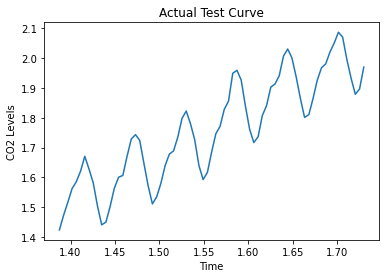

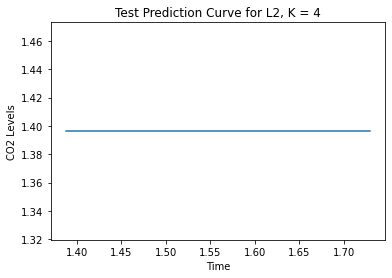

Test | K-Value: 4 | Average loss for L1: 0.4027682877240139 | Average loss for L2: 0.4027682877240139 | Time = 0.8794019222259521s


(0.4027682877240139, 0.4027682877240139)

In [49]:
# QUESTION 1: Main
from data_utils import load_dataset

# 1. Uncomment the dataset you'd like to work with.

print("Working with 'mauna_loa'...")
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')

#print("Working with 'rosenbrock'...")
#x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=1000, d=2)

#print("Working with 'pumadyn32nm'...")
#x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('pumadyn32nm')

# 2. Iterating over k to find the k estimate: 

for k in range(1,30):
    cross_validation_k(x_train, y_train, x_valid, y_valid, 28, partitions=5, plot=False)
    test_k(x_train, y_train, x_valid, y_valid, x_test, y_test, 4, plot=False)

# 3. Uncomment to retrieve loss plot.

#plot_loss(x_train, y_train, x_valid, y_valid, x_test, y_test, cv=True)

In [4]:
# QUESTION 2: Functions

# KD Tree Regression Function
# INPUT: All datasets (NxD np.arrays (X), Nx1 np.arrays (Y)), k value (int)
# OUTPUT: Test loss (float)
def knn_kdtree_regression(x_train, y_train, x_valid, y_valid, x_test, y_test, k_val):
    start = time.time()
    
    x_cross = np.vstack([x_valid,x_train])
    y_cross = np.vstack([y_valid,y_train])
    
    # Set up trees for train, valid, and test sets:
    tree_neighbours = KDTree(x_cross)
    pred_test = np.zeros((x_test.shape[0],1))
    
    # Find loss for nearest neighbours:
    nearest_dist_test, nearest_ind_test = tree_neighbours.query(x_test, k=k_val)
    
    it = 0 
    
    for inds in nearest_ind_test:
        pred_test[it,0] = np.average(y_cross[inds])
        it+=1
        
    test_loss = RMSEloss(y_test,pred_test)
    
    # Print results
    print(" K-Value: {} | Average loss for test: {} | Time = {}s".format(k_val,test_loss,(time.time()-start)))
    
    # Return loss values
    return test_loss

# RMSE Loss Function
# INPUT: Predicted Y array, actual Y array (NxD np.arrays)
# OUTPUT: Loss (float)
def RMSEloss(y_real,y_pred):
    return np.sqrt(np.mean((y_pred-y_real)**2))

Working with 'rosenbrock'...
Iteration 0
 K-Value: 5 | Average loss for test: 0.26680576927423627 | Time = 0.046892642974853516s
Test | K-Value: 5 | Average loss for L1: 1.2783462791791558 | Average loss for L2: 1.28664643309996 | Time = 1.2242040634155273s
Iteration 1
 K-Value: 5 | Average loss for test: 0.3790673006255698 | Time = 0.05241823196411133s
Test | K-Value: 5 | Average loss for L1: 1.2255184754569064 | Average loss for L2: 1.2289851481022316 | Time = 1.1695575714111328s
Iteration 2
 K-Value: 5 | Average loss for test: 0.4195481631141861 | Time = 0.0564579963684082s
Test | K-Value: 5 | Average loss for L1: 1.2251100704678861 | Average loss for L2: 1.2168674092717868 | Time = 1.2012572288513184s
Iteration 3
 K-Value: 5 | Average loss for test: 0.5208687829091821 | Time = 0.08298802375793457s
Test | K-Value: 5 | Average loss for L1: 1.176986605730216 | Average loss for L2: 1.166584217338423 | Time = 1.3171355724334717s
Iteration 4
 K-Value: 5 | Average loss for test: 0.6114880

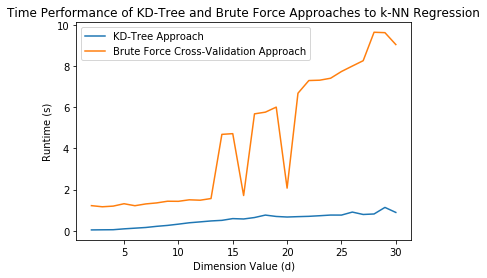

In [35]:
# QUESTION 2: Main

print("Working with 'rosenbrock'...")

# 1. Set up arrays for gathering runtime data.

x_vals = np.arange(2,31)
time_vals_tree = np.zeros(x_vals.size)
time_vals_brute = np.zeros(x_vals.size)
it = 0

# 2. Iterate over d value and collect runtime data:

for d_val in range(2,31):
    print("Iteration {}".format(it))
    x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=5000, d=d_val)
    start_tree = time.time()
    knn_kdtree_regression(x_train, y_train, x_valid, y_valid, x_test, y_test, 5)
    total_tree = time.time() - start_tree
    start_brute = time.time()
    test_k(x_train, y_train, x_valid, y_valid, x_test, y_test, 5, plot=False)
    total_brute = time.time() - start_brute
    time_vals_tree[it] = total_tree
    time_vals_brute[it] = total_brute
    it+=1
    
# 3. Plot runtime vs. d for KD approach, brute force approach

plt.plot(x_vals, time_vals_tree, label = "KD-Tree Approach")
plt.plot(x_vals, time_vals_brute, label = "Brute Force Cross-Validation Approach")
plt.xlabel('Dimension Value (d)')
# Set the y axis label of the current axis.
plt.ylabel('Runtime (s)')
# Set a title of the current axes.
plt.title('Time Performance of KD-Tree and Brute Force Approaches to k-NN Regression')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [5]:
# QUESTION 3: Functions

# KD tree classification function
# INPUT: All datasets (NxD np.arrays (X), Nx(# of classes) np.arrays (Y)), k (int), distance metric (str, 'L1' (2-norm) or 'L2' (1-norm)), whether to predict for validation data (True) or test data (bool)
# OUTPUT: Loss for L1, L2 (floats)
def knn_kdtree_classification(x_train, y_train, x_valid, y_valid, x_test, y_test, k_val, distance, valid=True):
    start = time.time()
    
    if distance == 'L1':
        metric_val = 'euclidean'
    elif distance == 'L2':
        metric_val = 'manhattan'
    else:
        return "Invalid Distance Metric"
    
    # Set up trees for train, valid, and test sets:
    if valid:
        tree_valid = KDTree(x_train,metric=metric_val)
        pred_valid = np.zeros((y_valid.shape[0],y_valid.shape[1]))
    else:
        x_cross = np.vstack([x_valid,x_train])
        y_cross = np.vstack([y_valid,y_train])
        tree_test = KDTree(x_cross,metric=metric_val)
        pred_test = np.zeros((y_test.shape[0],y_test.shape[1]))
    
    # Find accuracy for nearest neighbours:
    if valid:
        nearest_dist_valid, nearest_ind_valid = tree_valid.query(x_valid, k=k_val)
        
        it = 0
        for inds1 in nearest_ind_valid:
            neighbours = y_train[inds1]
            for i in range(neighbours.shape[1]):
                vote, count = np.unique(neighbours[:,i], return_counts=True)
                pred_valid[it,i] = vote[np.argmax(count)]
            it+=1
            
        pred_valid = pred_valid.astype(bool)
        valid_accuracy = accuracy(y_valid,pred_valid)
        
    else:
        nearest_dist_test, nearest_ind_test = tree_test.query(x_test, k=k_val)
        
        it = 0
        for inds2 in nearest_ind_test:
            neighbours = y_cross[inds2]
            for i in range(neighbours.shape[1]):
                vote, count = np.unique(neighbours[:,i], return_counts=True)
                pred_test[it,i] = vote[np.argmax(count)]
            it+=1
            
        pred_test = pred_test.astype(bool)
        test_accuracy = accuracy(y_test,pred_test)
    
    # Print results
    if valid:
        print("Metric: {} | K-Value: {} | Accuracy for valid: {} | Time = {}s".format(distance, k_val,valid_accuracy,(time.time()-start)))
    else:
        print("Metric: {} | K-Value: {} | Accuracy for test: {} | Time = {}s".format(distance, k_val,test_accuracy,(time.time()-start)))
    
    # Return accuracy values
    if valid:
        return valid_accuracy
    else:
        return test_accuracy
    
# Accuracy Function
# INPUT: Real Y array, predicted Y array (Nx(# of classes) np.arrays)
# OUTPUT: Accuracy of results (float percentage)
def accuracy(y_real,y_pred):
    count = 0
    for ind in range(y_real.shape[0]):
        it = 1
        for ind1 in range(y_real.shape[1]):
            if y_real[ind,ind1] != y_pred[ind,ind1]:
                it = 0
        count+=it
    return (count/(y_real.shape[0]))*100

# Reshape MNIST data for plotting
# INPUT: All X datasets (NxD np.arrays)
# OUTPUT: New X datasets (NxD np.arrays)
def reshape(x_train, x_valid, x_test):
    x_train = np.reshape(x_train,(10000,28,28),order='C')
    x_valid = np.reshape(x_valid,(1000,28,28),order='C')
    x_test = np.reshape(x_test,(1000,28,28),order='C')
    return x_train, x_valid, x_test

In [6]:
# QUESTION 3: Main

# 1. Uncomment dataset you'd like to work with.

#print("Working with 'iris'...")
#x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')

print("Working with 'mnist_small'...")
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mnist_small')
#x_train, x_valid, x_test = reshape(x_train, x_valid, x_test)

# 2. Set up arrays for accuracy data.

x_vals = np.arange(2,30)
test_acc1 = np.zeros(x_vals.size)
valid_acc1 = np.zeros(x_vals.size)
test_acc2 = np.zeros(x_vals.size)
valid_acc2 = np.zeros(x_vals.size)

# 3. Find k estimate by iterating through k.

it = 0
for k in range(2,30):
    valid_acc1[it] = knn_kdtree_classification(x_train, y_train, x_valid, y_valid, x_test, y_test, k, 'L1', valid=True)
    valid_acc2[it] = knn_kdtree_classification(x_train, y_train, x_valid, y_valid, x_test, y_test, k, 'L2', valid=True)
    test_acc1[it] = knn_kdtree_classification(x_train, y_train, x_valid, y_valid, x_test, y_test, k, 'L1', valid=False)
    test_acc2[it] = knn_kdtree_classification(x_train, y_train, x_valid, y_valid, x_test, y_test, k, 'L2', valid=False)
    it+=1

# 4. Plot accuracy for L1, L2   

plt.plot(x_vals, valid_acc1, label = "Valid Accuracy")
plt.plot(x_vals, test_acc1, label = "Test Accuracy")
plt.xlabel('k-Value')
# Set the y axis label of the current axis.
plt.ylabel('Accuracy')
# Set a title of the current axes.
plt.title('Accuracy vs. K for L1')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

plt.plot(x_vals, valid_acc2, label = "Valid Accuracy")
plt.plot(x_vals, test_acc2, label = "Test Accuracy")
plt.xlabel('k-Value')
# Set the y axis label of the current axis.
plt.ylabel('Accuracy')
# Set a title of the current axes.
plt.title('Accuracy vs. K for L2')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

Working with 'mnist_small'...


KeyboardInterrupt: 

In [31]:
# QUESTION 4: Functions

# SVD regression / classification function
# INPUT: All datasets (NxD np.arrays (X), Nx(# of classes) np.arrays (Y)), regression/classification task (str: "reg", "class")
# OUTPUT: Loss or accuracy (percent) for test predictions (float)
def svd_regclass(x_train, x_valid, x_test, y_train, y_valid, y_test, task): 
    start = time.time()
    
    # Combine train and validation data
    x_cross = np.vstack([x_valid,x_train])
    y_cross = np.vstack([y_valid,y_train])
    
    # Compute SVD
    x_svd = np.zeros((x_cross.shape[0],(x_cross.shape[1]+1)))
    x_svd[:,0] = np.ones((x_cross.shape[0]))
    x_svd[:,1:] = x_cross
    u, s, vT = np.linalg.svd(x_svd)
    
    # Form sigma matrix from singular values
    s1 = np.zeros((s.size,s.size))
    np.fill_diagonal(s1,s)
    
    # Calculate weights
    u1 = u[:,:s1.shape[0]]
    weights = np.transpose(vT).dot(np.linalg.inv(s1)).dot(np.transpose(u1)).dot(y_cross)
    
    # Calculate test points:
    X_test = np.zeros((x_test.shape[0],(x_test.shape[1]+1)))
    X_test[:,0] = np.ones((x_test.shape[0]))
    X_test[:,1:] = x_test
    y_hat = np.dot(X_test,weights)
    
    # Calculate loss/accuracy
    if task=="reg":
        loss = RMSEloss(y_test,y_hat)
    elif task=="class":
        acc = accuracy2(y_test,y_hat)
    else:
        return print("Invalid Task")
    
    # Return
    if task=="reg":
        print("Classification | Loss for test: {} | Time = {}s".format(loss,(time.time()-start)))
        return loss
    else:
        print("Classification | Accuracy for test: {} | Time = {}s".format(acc,(time.time()-start)))
        return acc

# Accuracy Function
# INPUT: Real Y array, predicted Y array (Nx(# of classes) np.arrays)
# OUTPUT: Accuracy of results (float percentage)
def accuracy2(y_real,y_pred):
    count = 0
    for line in range(y_real.shape[0]):
        if np.argmax(y_real[line])==np.argmax(y_pred[line]):
            count+=1
    return (count/(y_real.shape[0]))*100

In [34]:
# QUESTION 4: Main

# 1. Uncomment the dataset you'd like to work with.

#print("Working with 'mauna_loa'...")
#x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mauna_loa')

#print("Working with 'rosenbrock'...")
#x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('rosenbrock', n_train=1000, d=2)

#print("Working with 'pumadyn32nm'...")
#x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('pumadyn32nm')

print("Working with 'iris'...")
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')

#print("Working with 'mnist_small'...")
#x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('mnist_small')

# 2. Run SVD function to get accuracy/loss

svd_regclass(x_train, x_valid, x_test, y_train, y_valid, y_test, "class")

Working with 'iris'...
Classification | Accuracy for test: 86.66666666666667 | Time = 0.007703542709350586s


86.66666666666667